In [52]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pricing_benchmark import calculate_perp_priceV4 
from itertools import product

In [369]:
# positions to aggregate
num_samples = 150 # based on cash per trader and daily volume at gains
# param
trading_fee = 0.0001 # 'effective' fee, some may have a good broker and pay 0 bps, others 2 bps
# param
minimal_spread = 0.0001 
# param
incentive_spread = 0.0001 
# param
log_ret_sigma = 0.08 # > realized daily vol but close
# gains equivalent: 10
trade_size_mu = 10 
# hyper-param, ~ vol of trade sizes
trade_size_scale = 10 
# reference eth price
s_20 = 1_800 

In [370]:
# for box plot (not used yet)
trade_size_buckets = [[1,10], [10, 30], [30, 60], [60, 100], [100, 200], [200, 400], [400, 600], [600, 800], [800, 1_000]]
M_amounts = [250_000, 350_000, 500_000]

In [371]:
# grid
log_ret_mus = [-0.05, -0.01, 0, 0.01, 0.05]
prob_longs = [0.3, 0.4, 0.5, 0.6, 0.7]
num_iter = 200

In [372]:
def generate_state(log_ret_mu, log_ret_sigma, trade_size_mu, trade_size_scale, prob_long):
    # price today: use 50% of "implied vol" (calibrated vol) from starting price
    s_2 = np.exp(np.random.normal(log_ret_mu - 0.5 * (log_ret_sigma * 0.5)**2, log_ret_sigma * 0.5)) * s_20
    # trades
    trade_sizes = np.random.gamma(trade_size_mu / trade_size_scale, trade_size_scale, num_samples)
    trade_dirs = np.where(np.random.uniform(size=num_samples) < prob_long, 1,-1)
    trade_amounts = trade_sizes * trade_dirs
    # aggregate
    L1 = np.sum(s_20 * trade_amounts)
    K2 = np.sum(trade_amounts)
    oi_long = np.sum(trade_amounts[trade_amounts>0]) # > 0
    oi_short = -np.sum(trade_amounts[trade_amounts<0]) # > 0
    volume = np.sum(trade_sizes * s_20)
    res = (K2, L1, s_2, np.mean(trade_sizes), volume, np.max((oi_long, oi_short))/(oi_long + oi_short))
    # print(res)
    return res

In [373]:
grid = product(log_ret_mus, prob_longs, range(num_iter))
states = [generate_state(log_ret_mu, log_ret_sigma, trade_size_mu, trade_size_scale, prob_long) for log_ret_mu, prob_long, _ in grid]
print(np.mean(np.array(states), axis=0))
print(np.std(np.array(states), axis=0))

[9.05385703e-01 1.62969427e+03 1.80066060e+03 1.00144285e+01
 2.70389571e+06 6.30142158e-01]
[4.58000905e+02 8.24401629e+05 9.23023430e+01 8.21161483e-01
 2.21713601e+05 7.83609596e-02]


In [374]:
def get_slippage(k, M):
    grid = product(log_ret_mus, prob_longs, range(num_iter))
    states = [generate_state(log_ret_mu, log_ret_sigma, trade_size_mu, trade_size_scale, prob_long) for log_ret_mu, prob_long, _ in grid]
    amm_pnl = [(M - K2 * s2 + L1 + (trading_fee + minimal_spread + incentive_spread) * vol)/M-1.0 
               for K2, L1, s2, pos_size_ema, vol, oi_imbalance in states]
    slippages = [calculate_perp_priceV4(K2, k, L1, s2, 1, log_ret_sigma, 1, 0, 0, M+(trading_fee + minimal_spread+incentive_spread) * vol, 0, 0, minSpread=minimal_spread, incentiveSpread=incentive_spread, k_bar=pos_size_ema) / s2 - 1
                 for K2, L1, s2, pos_size_ema, vol, oi_imbalance in states]
    imbalance = np.array([s[5] for s in states])
    s2 = np.array([s[2] for s in states])
    K2 = np.array([s[0] for s in states])
    volumes = np.array([s[4] for s in states])
    return np.array(slippages), np.array(imbalance), np.array(amm_pnl), K2, s2, volumes

In [375]:
slippages, imbalances, amm_pnl, K2, s2, volumes = get_slippage(100, M_amounts[1])
for i in np.random.choice(len(slippages), size=10, replace=False):
    print(f"Liquidity: ${M_amounts[1]}, AMM PnL: %{amm_pnl[i]: .2f}, Slippage: {slippages[i] * 1e4: .3f} bps, K2 = {K2[i]: .1f} ETH, OI (max/total) = %{100 * imbalances[i]:.1f}")

Liquidity: $350000, AMM PnL: %-0.22, Slippage:  2.000 bps, K2 = -375.5 ETH, OI (max/total) = %63.1
Liquidity: $350000, AMM PnL: %-0.01, Slippage:  2.000 bps, K2 = -366.3 ETH, OI (max/total) = %63.0
Liquidity: $350000, AMM PnL: %-0.02, Slippage:  2.000 bps, K2 = -144.4 ETH, OI (max/total) = %55.5
Liquidity: $350000, AMM PnL: % 0.00, Slippage:  2.000 bps, K2 = -25.5 ETH, OI (max/total) = %50.8
Liquidity: $350000, AMM PnL: %-0.05, Slippage:  4.513 bps, K2 =  472.4 ETH, OI (max/total) = %64.1
Liquidity: $350000, AMM PnL: % 0.01, Slippage:  2.000 bps, K2 =  69.8 ETH, OI (max/total) = %52.3
Liquidity: $350000, AMM PnL: % 0.02, Slippage:  2.000 bps, K2 =  86.4 ETH, OI (max/total) = %53.0
Liquidity: $350000, AMM PnL: % 0.12, Slippage:  2.000 bps, K2 = -408.2 ETH, OI (max/total) = %64.2
Liquidity: $350000, AMM PnL: % 0.01, Slippage:  2.000 bps, K2 =  141.9 ETH, OI (max/total) = %54.6
Liquidity: $350000, AMM PnL: % 0.01, Slippage:  2.000 bps, K2 = -30.9 ETH, OI (max/total) = %51.1


16.208906034662785
[ 1.99999958  2.          2.          2.08955331 13.43746913]


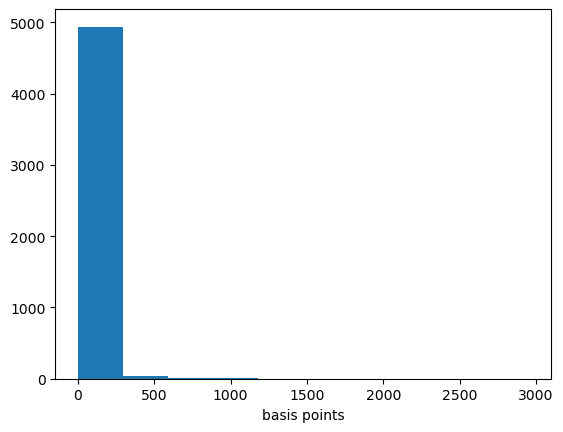

In [376]:
# with all points
plt.hist(np.abs(slippages) *1e4, 10)
plt.xlabel('basis points')
print(np.mean(np.abs(slippages) * 1e4))
print(np.quantile(np.abs(slippages), [0.1, 0.25, 0.5, 0.75, 0.9]) * 1e4)


3.466796619390927
[2.         2.         2.         2.0003151  3.01633327]


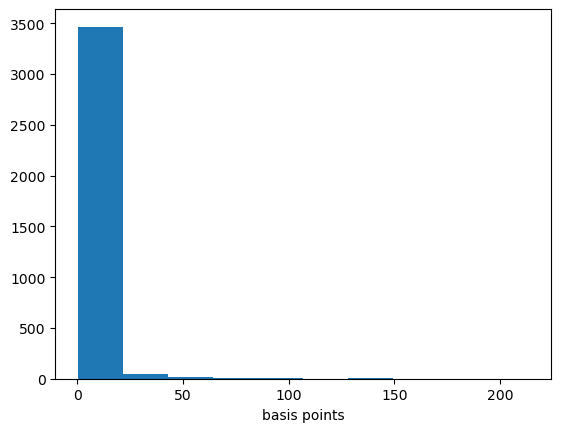

In [377]:
# dropping extreme one-sided-tradinhg cases (>70%)
mask = (imbalances <= 0.6) | (K2 * (s2 - s_20) < 0)
plt.hist(np.abs(slippages[mask]) *1e4, 10)
plt.xlabel('basis points')
print(np.mean(np.abs(slippages[mask]) * 1e4))
print(np.quantile(np.abs(slippages[mask]), [0.1, 0.25, 0.5, 0.75, 0.9]) * 1e4)
# plt.scatter(np.abs(slippages)[mask], imbalances[mask])

Text(0.5, 0, 'mmUSD')

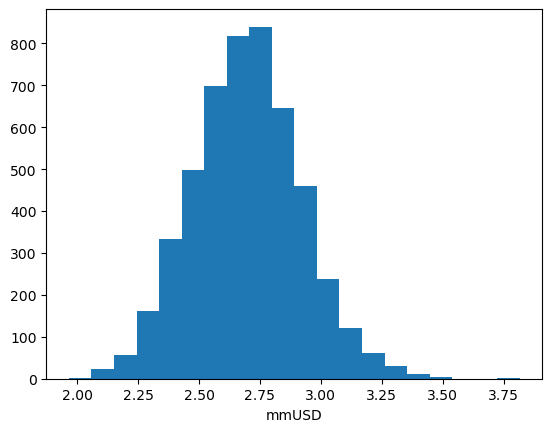

In [378]:
plt.hist(volumes / 1e6, 20)
plt.xlabel('mmUSD')

In [414]:
df = pd.DataFrame(columns=['slippage', 'trade_size', 'liquidity'])
for k in [0.1, 1, 5, 10, 25, 50, 100, 150, 200, 300, 500, 1000]:
    for M in [250_000, 300_000, 400_000, 600_000]:
        slips = np.abs(get_slippage(k, M)[0])
        df_tmp = pd.DataFrame(
            {'slippage': slips, 'trade_size': np.repeat(k,slips.shape[0]), 'liquidity': np.repeat(f"{M/1e6:.2f} mmUSD", slips.shape[0])}
        )
        df = pd.concat([df, df_tmp], axis=0)
df.head()

,slippage,trade_size,liquidity
0,0.010328,0.1,0.25 mmUSD
1,0.000293,0.1,0.25 mmUSD
2,0.000100,0.1,0.25 mmUSD
3,0.000102,0.1,0.25 mmUSD
4,0.001934,0.1,0.25 mmUSD


/tmp/ipykernel_193676/2093762622.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.iloc[i].set_yticklabels([f"{y * 1e4:.0f}" for y in yticks])


(1e-05, 0.5)

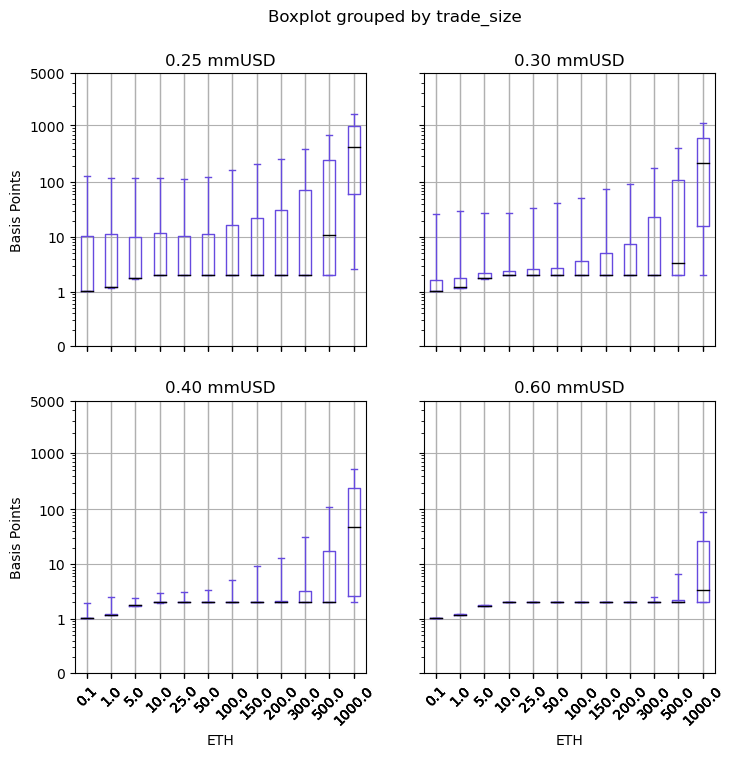

In [462]:
title_boxplot = "Slippage across trade sizes for different liquidity assumptions"
medianprops = dict(linestyle='-', color='#000000')

ax = df.groupby("liquidity").boxplot(
    by=["trade_size"],showfliers=False, return_type=None, whis=(10,90), figsize=(8,8), layout = (2, 2), 
    sharey=True, sharex=True, xlabel='ETH', ylabel='Basis Points',medianprops=medianprops, rot=45, color="#664ADF")

for i in range(ax.shape[0]):
    ax.iloc[i].set_yscale('logit')
    yticks = ax.iloc[i].get_yticks()
    ax.iloc[i].set_yticklabels([f"{y * 1e4:.0f}" for y in yticks])



ax.iloc[1].set_yticks(ax.iloc[0].get_yticks())
ax.iloc[1].set_ylim(ax.iloc[0].get_ylim())

ax.iloc[3].set_yticks(ax.iloc[2].get_yticks())
ax.iloc[3].set_ylim(ax.iloc[2].get_ylim())

